In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import AdamW
from sklearn.utils.class_weight import compute_class_weight

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV

import pickle

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
train_data = pd.read_csv('drive/MyDrive/vk_classification/train_spam.csv')

**Аналитика данных**

In [9]:
train_data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [10]:
train_data.describe()

,text_type,text
count,16278,16278
unique,2,16267
top,ham,SPAM ALERT 🚔 User: Username: @DillyBubbl...
freq,11469,7


In [11]:
train_data['text_type'].unique()

array(['ham', 'spam'], dtype=object)

In [12]:
train_data.isna().sum()

text_type    0
text         0
dtype: int64

In [13]:
train_data['text_type'] = train_data['text_type'].apply(lambda x: 1 if x == 'spam' else 0)

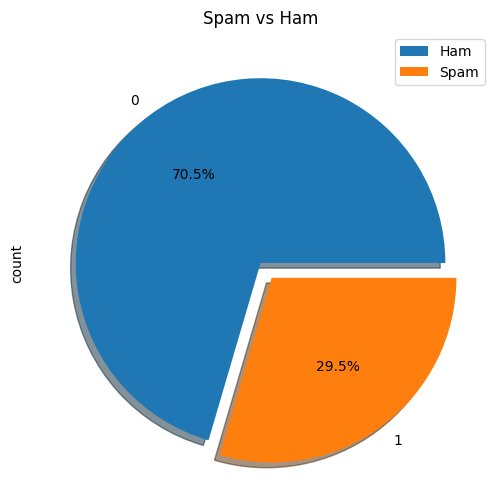

In [14]:
train_data["text_type"].value_counts().plot(kind = 'pie',explode=[0, 0.1],figsize=(6, 6),autopct='%1.1f%%',shadow=True)
plt.title("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

In [15]:
def text_preprocess(text): #предобработка текста
    no_punc = [char for char in text if char not in string.punctuation]

    no_punc = ''.join(no_punc)
    no_punc = no_punc.lower()

    #преобразование текста в нижний регистр, избавление от стоп-слов
    no_stop_words = [word for word in no_punc.split() if word.lower() not in stopwords.words('english') and word.isalpha()]

    #стеблизация
    stemmer = PorterStemmer()
    result = ' '.join([stemmer.stem(word) for word in no_stop_words])
    return result

In [16]:
train_data['text'] = train_data['text'].apply(text_preprocess)

In [17]:
train_data.head()

,text_type,text
0,0,make sure alex know birthday fifteen minut far...
1,0,resum john lavorato thank vinc get move right ...
2,1,plzz visit websit moviesgodml get movi free al...
3,1,urgent mobil number award prize guarante call ...
4,0,overview hr associ analyst project per david r...


In [18]:
train_data.to_csv('processed_data.csv', encoding='utf-8', index=False)

In [19]:
train_data['text'].isna().sum()

0

In [20]:
train_data.dropna(inplace=True)

In [21]:
train_data['length'] = train_data['text'].apply(len)

In [22]:
train_data.head()

,text_type,text,length
0,0,make sure alex know birthday fifteen minut far...,59
1,0,resum john lavorato thank vinc get move right ...,345
2,1,plzz visit websit moviesgodml get movi free al...,85
3,1,urgent mobil number award prize guarante call ...,67
4,0,overview hr associ analyst project per david r...,572


array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

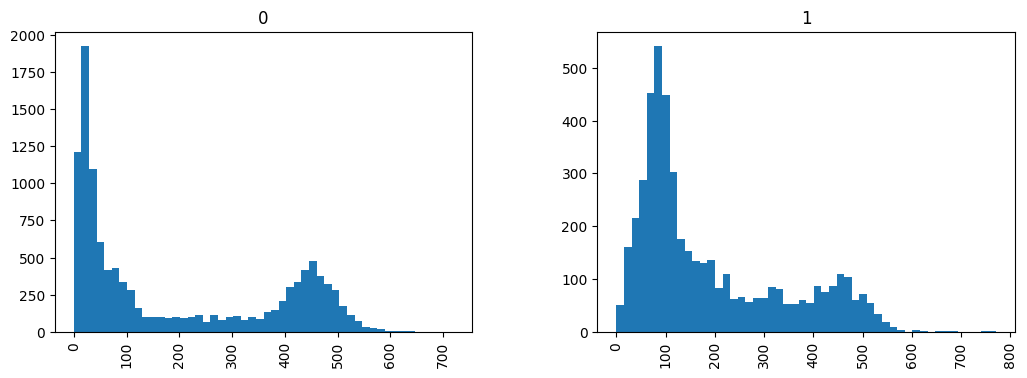

In [23]:
train_data.hist(column='length', by='text_type', bins=50,figsize=(12,4))

In [24]:
def vectorization(data): #векторизация
  bow_transformer = CountVectorizer(max_features=16810).fit(data['text'])
  bow = bow_transformer.transform(data['text'])

  tfidf_transformer = TfidfTransformer().fit(bow)
  tfidf_vect = tfidf_transformer.transform(bow)

  return tfidf_vect

**Анализ нескольких подходов**

In [25]:
def TrainTestSplit(vect, data):
  X_train, X_test, y_train, y_test = train_test_split(vect, data['text_type'], test_size=0.3, shuffle=True)
  return X_train, X_test, y_train, y_test

In [26]:
def get_predict(classifier, X_train, y_train, X_test):
  classifier.fit(X_train, y_train)
  return classifier.predict(X_test)

In [27]:
vect = vectorization(train_data)

X_train, X_test, y_train, y_test = TrainTestSplit(vect, train_data)

In [28]:
svm = SVC()
dtree = DecisionTreeClassifier()
mnb = MultinomialNB()
knn = KNeighborsClassifier()
rfc = RandomForestClassifier()
ada_boost = AdaBoostClassifier()
bagging_clf = BaggingClassifier()

In [29]:
classifiers = {'SVM': svm, 'Decision Tree': dtree, 'Multinomial NB': mnb, 'KNN': knn, 'Random Forest': rfc,
                   'AdaBoost': ada_boost, 'Bagging Classifier': bagging_clf}

pred = dict()
scores = []
for k, v in classifiers.items():
  pred[k] = get_predict(v, X_train, y_train, X_test)
  scores.append((k, [accuracy_score(y_test, pred[k]), roc_auc_score(y_test, pred[k])]))
  print('\n############### ' + k + ' ###############\n')
  print(classification_report(y_test, pred[k]))
  print(roc_auc_score(y_test, pred[k]))


############### SVM ###############

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      3444
           1       0.94      0.83      0.88      1440

    accuracy                           0.93      4884
   macro avg       0.94      0.90      0.92      4884
weighted avg       0.93      0.93      0.93      4884

0.9046481804103755

############### Decision Tree ###############

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      3444
           1       0.81      0.81      0.81      1440

    accuracy                           0.89      4884
   macro avg       0.86      0.87      0.86      4884
weighted avg       0.89      0.89      0.89      4884

0.8656564556716997

############### Multinomial NB ###############

              precision    recall  f1-score   support

           0       0.88      0.97      0.93      3444
           1       0.91      0.69      0.79      1440

    accur

In [30]:
scores

[('SVM', [0.9344799344799345, 0.9046481804103755]),
 ('Decision Tree', [0.8871826371826372, 0.8656564556716997]),
 ('Multinomial NB', [0.8892301392301393, 0.8317508710801393]),
 ('KNN', [0.7536855036855037, 0.5833018776616338]),
 ('Random Forest', [0.9328419328419328, 0.8972234320557492]),
 ('AdaBoost', [0.8714168714168714, 0.8193222512582268]),
 ('Bagging Classifier', [0.9113431613431613, 0.8864244579945799])]

**Пробуем улучшить результаты при помощи GridSearch**

In [31]:
def MultiNominalNB_Tuning(X_train, X_test, y_train, y_test):

    print('\n############### Multinomial NB ###############\n')
    param_grid = {'alpha': np.arange(0.05, 1.05, 0.05)}
    model = GridSearchCV(MultinomialNB(), param_grid, verbose = 1)
    model.fit(X_train, y_train)

    print('\nBest parameter:', model.best_params_)

    pred = model.predict(X_test)

    print('\nAccuracy Score:', accuracy_score(y_test, pred))
    print('\n')
    print(classification_report(y_test, pred))
    print('\n')
    print('\nROC-AUC score:', roc_auc_score(y_test, pred))

    return model

In [32]:
def DecisionTree_Tuning(X_train, X_test, y_train, y_test):

    print('\n############### Decision Tree ###############\n')
    param_grid = {'min_samples_split': np.arange(5, 20, 1)}

    model = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose = 1)
    model.fit(X_train, y_train)

    print('\nBest parameter:', model.best_params_)

    pred = model.predict(X_test)

    print('\nAccuracy Score:', accuracy_score(y_test, pred))
    print('\n')
    print(classification_report(y_test, pred))
    print('\n')
    print('\nROC-AUC score:', roc_auc_score(y_test, pred))

    return model

In [33]:
def SVM_Tuning(X_train, X_test, y_train, y_test):

    print('\n############### SVM ###############\n')
    param_grid = {'kernel':['rbf','sigmoid','linear'], 'gamma':[1, 0.1, 0.01, 0.001]}

    model = GridSearchCV(SVC(), param_grid, verbose = 3)
    model.fit(X_train, y_train)

    print('\nBest parameter:', model.best_params_)

    pred = model.predict(X_test)

    print('\nAccuracy Score:', accuracy_score(y_test, pred))
    print('\n')
    print(classification_report(y_test, pred))
    print('\n')
    print('\nROC-AUC score:', roc_auc_score(y_test, pred))

    return model

In [34]:
MNB_model = MultiNominalNB_Tuning(X_train, X_test, y_train, y_test)
DecTree_model = DecisionTree_Tuning(X_train, X_test, y_train, y_test)
SVM_model = SVM_Tuning(X_train, X_test, y_train, y_test)


############### Multinomial NB ###############

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameter: {'alpha': 0.1}

Accuracy Score: 0.916052416052416


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3444
           1       0.87      0.84      0.86      1440

    accuracy                           0.92      4884
   macro avg       0.90      0.89      0.90      4884
weighted avg       0.92      0.92      0.92      4884




ROC-AUC score: 0.8938044425087108

############### Decision Tree ###############

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best parameter: {'min_samples_split': 6}

Accuracy Score: 0.8888206388206388


              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3444
           1       0.80      0.82      0.81      1440

    accuracy                           0.89      4884
   macro avg       0.86      0.87      0.87      

Наилучшие результаты показала модель SVM, сохраним ее для последующего использования

In [35]:
with open('svm_model_0.0.1.pkl', 'wb') as f: #сохранение наилучшей модели
  pickle.dump(SVM_model, f)

**BERT**

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(train_data['text'], train_data['text_type'], test_size=0.3)
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, test_size=0.5)

In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased')

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT(nn.Module):

    def __init__(self, bert):
        super(BERT, self).__init__()

        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):

        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        x = self.softmax(x)

        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = BERT(bert)
model = model.to(device)

In [ ]:
optimizer = AdamW(model.parameters(),lr = 1e-6)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

In [ ]:
print("Class Weights:",class_weights)

Class Weights: [0.70805369 1.7016129 ]


In [ ]:
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)
cross_entropy  = nn.NLLLoss(weight=weights)
epochs = 5

In [ ]:
def train():

    model.train()
    total_loss, total_accuracy = 0, 0

    total_preds=[]
    for step,batch in enumerate(train_dataloader):

        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        batch = [i.to(device) for i in batch]

        sent_id, mask, labels = batch
        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)
        total_loss = total_loss + loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds=preds.detach().cpu().numpy()

    total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

In [ ]:
def evaluate():

    print("\nEvaluating...")

    model.eval()

    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step,batch in tqdm(enumerate(val_dataloader)):

        if step % 50 == 0 and not step == 0:

            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds,labels)
            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)

    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.537
Validation Loss: 0.528

 Epoch 2 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.528
Validation Loss: 0.520

 Epoch 3 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.522
Validation Loss: 0.511

 Epoch 4 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.519
Validation Loss: 0.506

 Epoch 5 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.513
Validation Loss: 0.500

 Epoch 6 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.510
Validation Loss: 0.495

 Epoch 7 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.503
Validation Loss: 0.491

 Epoch 8 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.495
Validation Loss: 0.486

 Epoch 9 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.498
Validation Loss: 0.483

 Epoch 10 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.491
Validation Loss: 0.481

 Epoch 11 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.489
Validation Loss: 0.475

 Epoch 12 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.487
Validation Loss: 0.473

 Epoch 13 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.482
Validation Loss: 0.469

 Epoch 14 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.478
Validation Loss: 0.465

 Epoch 15 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.478
Validation Loss: 0.463

 Epoch 16 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.474
Validation Loss: 0.464

 Epoch 17 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.468
Validation Loss: 0.458

 Epoch 18 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.467
Validation Loss: 0.459

 Epoch 19 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.469
Validation Loss: 0.453

 Epoch 20 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.463
Validation Loss: 0.456

 Epoch 21 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.462
Validation Loss: 0.454

 Epoch 22 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.463
Validation Loss: 0.448

 Epoch 23 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.456
Validation Loss: 0.446

 Epoch 24 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.456
Validation Loss: 0.447

 Epoch 25 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.452
Validation Loss: 0.445

 Epoch 26 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.454
Validation Loss: 0.444

 Epoch 27 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.451
Validation Loss: 0.439

 Epoch 28 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.451
Validation Loss: 0.440

 Epoch 29 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.448
Validation Loss: 0.435

 Epoch 30 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.447
Validation Loss: 0.433

 Epoch 31 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.449
Validation Loss: 0.434

 Epoch 32 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.442
Validation Loss: 0.432

 Epoch 33 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.442
Validation Loss: 0.430

 Epoch 34 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.442
Validation Loss: 0.428

 Epoch 35 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.438
Validation Loss: 0.428

 Epoch 36 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.439
Validation Loss: 0.428

 Epoch 37 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.438
Validation Loss: 0.424

 Epoch 38 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.438
Validation Loss: 0.427

 Epoch 39 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.428
Validation Loss: 0.422

 Epoch 40 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.434
Validation Loss: 0.422

 Epoch 41 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.434
Validation Loss: 0.420

 Epoch 42 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.433
Validation Loss: 0.424

 Epoch 43 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.429
Validation Loss: 0.422

 Epoch 44 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.431
Validation Loss: 0.429

 Epoch 45 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.428
Validation Loss: 0.417

 Epoch 46 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.432
Validation Loss: 0.416

 Epoch 47 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.427
Validation Loss: 0.418

 Epoch 48 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.427
Validation Loss: 0.421

 Epoch 49 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.424
Validation Loss: 0.416

 Epoch 50 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.428
Validation Loss: 0.413

 Epoch 51 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.420
Validation Loss: 0.413

 Epoch 52 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.422
Validation Loss: 0.411

 Epoch 53 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.427
Validation Loss: 0.411

 Epoch 54 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.423
Validation Loss: 0.411

 Epoch 55 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.417
Validation Loss: 0.408

 Epoch 56 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.421
Validation Loss: 0.409

 Epoch 57 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.423
Validation Loss: 0.409

 Epoch 58 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.422
Validation Loss: 0.407

 Epoch 59 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.418
Validation Loss: 0.407

 Epoch 60 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.422
Validation Loss: 0.407

 Epoch 61 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.418
Validation Loss: 0.411

 Epoch 62 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.422
Validation Loss: 0.409

 Epoch 63 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.415
Validation Loss: 0.404

 Epoch 64 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.421
Validation Loss: 0.407

 Epoch 65 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.416
Validation Loss: 0.404

 Epoch 66 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.418
Validation Loss: 0.406

 Epoch 67 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.413
Validation Loss: 0.403

 Epoch 68 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.413
Validation Loss: 0.402

 Epoch 69 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.412
Validation Loss: 0.401

 Epoch 70 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.413
Validation Loss: 0.402

 Epoch 71 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.412
Validation Loss: 0.398

 Epoch 72 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.408
Validation Loss: 0.400

 Epoch 73 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.413
Validation Loss: 0.404

 Epoch 74 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.412
Validation Loss: 0.398

 Epoch 75 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.410
Validation Loss: 0.397

 Epoch 76 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.408
Validation Loss: 0.398

 Epoch 77 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.409
Validation Loss: 0.398

 Epoch 78 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.414
Validation Loss: 0.397

 Epoch 79 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.410
Validation Loss: 0.399

 Epoch 80 / 80
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.413
Validation Loss: 0.399


In [ ]:
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, _ = train()
    valid_loss, _ = evaluate()

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 5
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.405
Validation Loss: 0.396

 Epoch 2 / 5
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.409
Validation Loss: 0.397

 Epoch 3 / 5
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.403
Validation Loss: 0.396

 Epoch 4 / 5
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.404
Validation Loss: 0.396

 Epoch 5 / 5
  Batch    50  of    357.
  Batch   100  of    357.
  Batch   150  of    357.
  Batch   200  of    357.
  Batch   250  of    357.
  Batch   300  of    357.
  Batch   350  of    357.

Evaluating...


0it [00:00, ?it/s]

  Batch    50  of     77.

Training Loss: 0.406
Validation Loss: 0.397


In [ ]:
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))
print(f'ROC-AUC score: {roc_auc_score(test_y, preds)}')

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1704
           1       0.69      0.76      0.72       738

    accuracy                           0.82      2442
   macro avg       0.79      0.80      0.79      2442
weighted avg       0.83      0.82      0.82      2442

ROC-AUC score: 0.8039929959158747


**Работа с тестовыми данными**

In [44]:
test_data = pd.read_csv('drive/MyDrive/vk_classification/test_spam.csv')

In [45]:
test_data.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [46]:
test_data.isna().sum()

text    0
dtype: int64

In [47]:
test_data['text'] = test_data['text'].apply(text_preprocess)

In [48]:
test_data['text'].isna().sum()

0

In [49]:
res_bow_transformer = CountVectorizer().fit(test_data['text'])
res_bow = res_bow_transformer.transform(test_data['text'])

res_tfidf_transformer = TfidfTransformer().fit(res_bow)
res_tfidf_vect = res_tfidf_transformer.transform(res_bow)

In [50]:
preds = SVM_model.predict(res_tfidf_vect)

In [ ]:
test_data['score'] = preds

In [59]:
test_data.to_csv('results.csv', encoding='utf-8', index=False)